# Titanic: Classifier/ Logistic Regression





This project approaches a classic Machine Learning problem, with a classication model, in order to predict passenger survival on the Titanic. With python and sklearn library, after a detailed process of feature engineering, I was able to train a Random Forest and Logistic Regression model with accuracy scores inbetween 78% and 81%. A k-fold Cross Validation was used to test the machine learning models and presented consistent scores around 79%.

## 1) Define business goal 

- The Titanic passenger list can be used for an exercise classification task: Given the data of a new passenger, we want to predict whether they will survive the disaster.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, f1_score, plot_confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score


## 2) Get data

In [2]:
df = pd.read_csv('train.csv',index_col=0)
df.head()     

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.columns=df.columns.str.lower()       #It's better to have columns titles in lowercase
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Cabin has the name of the floor on the ship. A is on top, maybe has more probabilty to survive?
It is nice to keep this info, but we just need the letter, not the number below.
Moreover, we need to replace NaN, but we do it later with Featuring Enginnering.

In [4]:
df.shape   

(891, 11)

In [5]:
df.describe()   

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Replace missing values on dataset

<AxesSubplot:ylabel='PassengerId'>

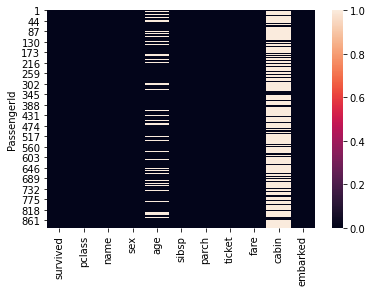

In [6]:
# missing info
sns.heatmap(df.isna())

In [7]:
df.isna().sum() 
#I will replace NaN in Age and cabin

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

### Replace missing age values by the mean age of every pclass

In [8]:
df['age'].mean()

29.69911764705882

In [9]:
df.groupby('pclass')['age'].mean()

pclass
1    38.233441
2    29.877630
3    25.140620
Name: age, dtype: float64

In [10]:
df['age'].fillna(df.groupby('pclass').transform('mean')['age'], inplace=True)

In [11]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Replace missing cabin values with "m"

In [12]:
df['cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [13]:
df['cabin'] = df['cabin'].fillna('m')

In [15]:
df['cabin'] = df['cabin'].replace('^.*A.*$', 'A', regex=True)
df['cabin'] = df['cabin'].replace('^.*B.*$', 'B', regex=True)
df['cabin'] = df['cabin'].replace('^.*C.*$', 'C', regex=True)
df['cabin'] = df['cabin'].replace('^.*D.*$', 'D', regex=True)
df['cabin'] = df['cabin'].replace('^.*E.*$', 'E', regex=True)
df['cabin'] = df['cabin'].replace('^.*F.*$', 'F', regex=True)
df['cabin'] = df['cabin'].replace('^.*G.*$', 'G', regex=True)
df['cabin']                         

PassengerId
1      m
2      C
3      m
4      C
5      m
      ..
887    m
888    B
889    m
890    C
891    m
Name: cabin, Length: 891, dtype: object

In [16]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,m,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,m,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,m,S


### Replace missing embarked values with the most frequent

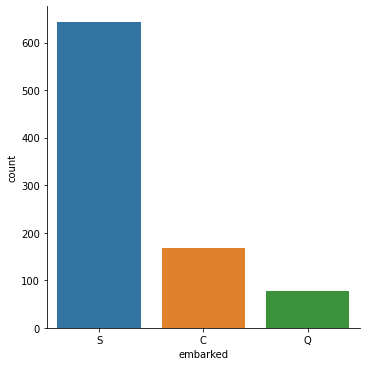

In [17]:
sns.catplot(x = 'embarked', kind = 'count', data = df)

In [18]:
df['embarked'] = df['embarked'].fillna('S')     #most frequent
df.isna().sum()

survived    0
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
cabin       0
embarked    0
dtype: int64

# EDA

#### Age

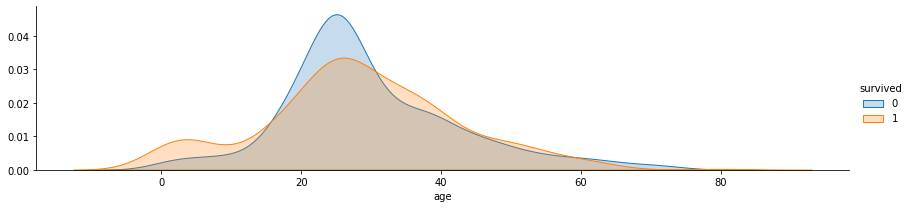

In [21]:
a = sns.FacetGrid( df, hue = 'survived',  aspect=4 )
a.map(sns.kdeplot, 'age', shade= True )
a.add_legend()

#### Fare

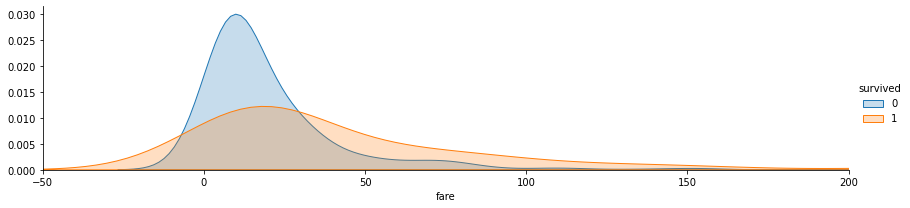

In [24]:
a = sns.FacetGrid( df, hue = 'survived',  aspect=4 )
a.map(sns.kdeplot, 'fare', shade= True )
a.add_legend()
a.set(xlim=(-50,200))

#### Sex

/home/dani/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


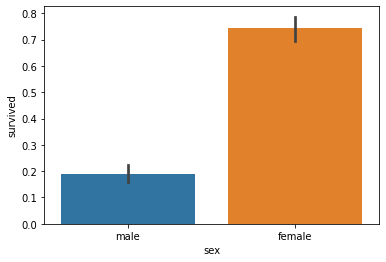

In [25]:
sns.barplot('sex', 'survived', data=df);

#### Embarked

<AxesSubplot:xlabel='embarked', ylabel='survived'>

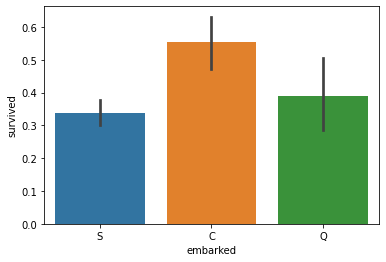

In [27]:
sns.barplot('embarked','survived', data=df)

#### Pclass

<AxesSubplot:xlabel='pclass', ylabel='survived'>

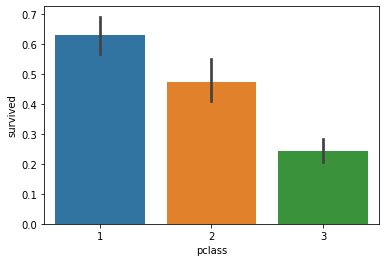

In [29]:
sns.barplot('pclass', 'survived', data=df)

#### SibSp

<AxesSubplot:xlabel='sibsp', ylabel='survived'>

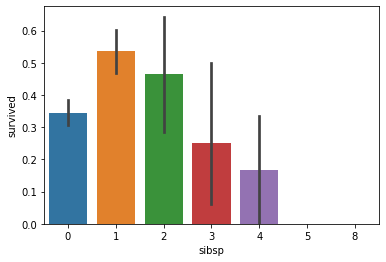

In [31]:
sns.barplot('sibsp', 'survived', data=df)

#### Parch

/home/dani/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='parch', ylabel='survived'>

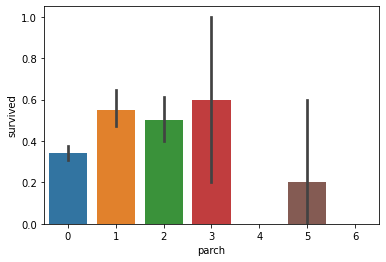

In [32]:
sns.barplot('parch', 'survived', data=df)

<AxesSubplot:xlabel='age', ylabel='sex'>

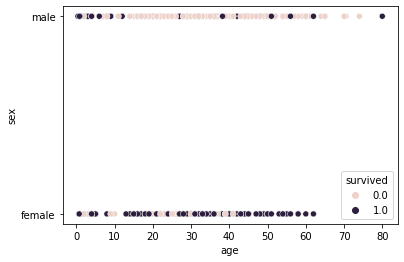

In [68]:
sns.scatterplot(data=df, x='age', y='sex', hue=y_train)

<AxesSubplot:xlabel='pclass', ylabel='parch'>

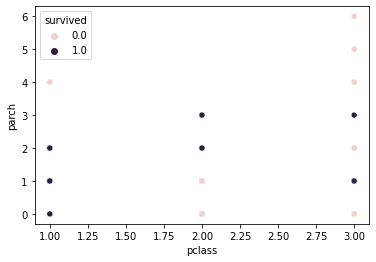

In [69]:
sns.scatterplot(data=df, x='pclass', y='parch', hue=y_train)

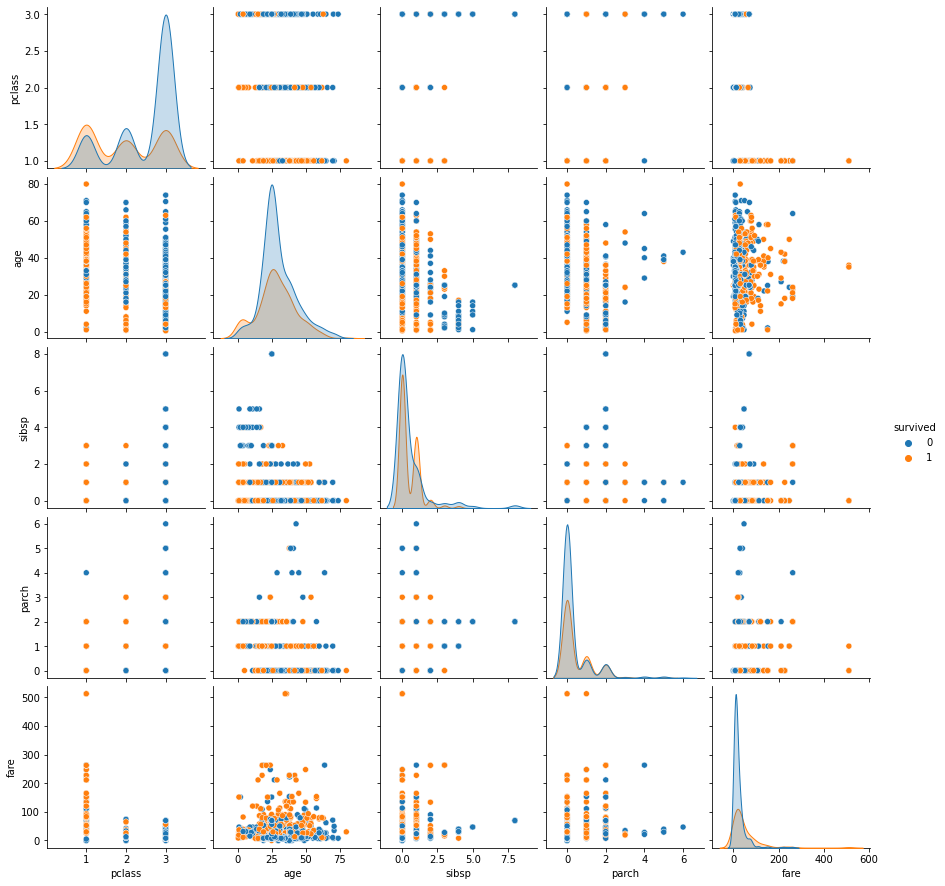

In [19]:
# shape of data
sns.pairplot(df, hue='survived')

<AxesSubplot:>

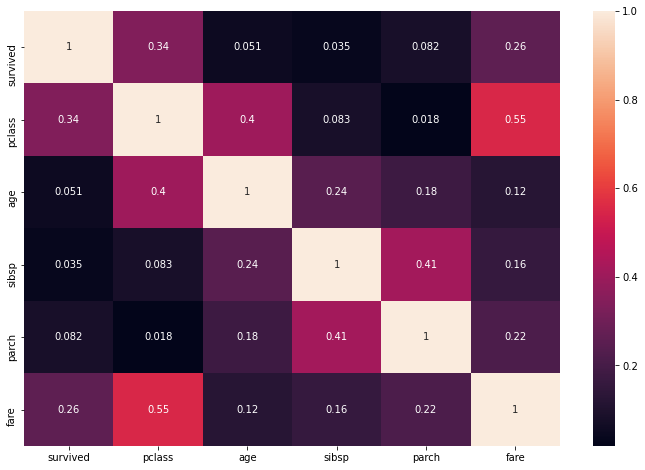

In [35]:
# strength of correlation: feature-feature, and feature-dependent variable
# using an absolute correlation as it is the magnitude of correlation, not direction, that we are interested in
plt.figure(figsize=(12,8))
sns.heatmap(df.corr().abs(), annot=True)

  ### Select columns for y and X

In [36]:
# independent variables
X = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked', 'fare', 'cabin']]

#  dependent variable. We want to predit y from X
y = df['survived']

In [37]:
y.shape, X.shape

((891,), (891, 8))

## 3) Train-test-split


In [38]:
# Split the DataFrame into X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [39]:
X_train.shape, X_test.shape

((668, 8), (223, 8))

## 4) Feature Engineering

Will be based on my EDA. I want to preprocessing data before building the model.




In [43]:
df.dtypes

survived      int64
pclass        int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

In [44]:
#we put all the data transformer inside a ColumnTransformer.
#scale the "fare" column
#impute and change categorial to binary values in "cabin" column
#change categorial to binary values in "embarked" and "sex" column
#you should put all the columns in ColumTransformer, even if don't want to change nothing(passthrough)

trans = ColumnTransformer([             #list of transformers with (name,method,columns)
    ('minmax', MinMaxScaler(),['fare']),
    ('onehot', OneHotEncoder(sparse=False), ['embarked','sex','cabin']),
    ('do_nothing', 'passthrough', ['parch', 'sibsp','pclass','age'])
    ])

In [45]:
trans.fit(X_train)

ColumnTransformer(transformers=[('minmax', MinMaxScaler(), ['fare']),
                                ('onehot', OneHotEncoder(sparse=False),
                                 ['embarked', 'sex', 'cabin']),
                                ('do_nothing', 'passthrough',
                                 ['parch', 'sibsp', 'pclass', 'age'])])

## 6) Fit  a model

In [46]:
X_train

,pclass,sex,age,sibsp,parch,embarked,fare,cabin
PassengerId,,,,,,,,
299,1,male,38.233441,0,0,S,30.5000,C
885,3,male,25.000000,0,0,S,7.0500,m
248,2,female,24.000000,0,2,S,14.5000,m
479,3,male,22.000000,0,0,S,7.5208,m
306,1,male,0.920000,1,2,S,151.5500,C
...,...,...,...,...,...,...,...,...
107,3,female,21.000000,0,0,S,7.6500,m
271,1,male,38.233441,0,0,S,31.0000,m
861,3,male,41.000000,2,0,S,14.1083,m


In [47]:
X_train_trans = trans.transform(X_train)   #wdefine X_trains_trans to train the model with the transformed data
X_test_trans = trans.transform(X_test)

In [48]:
X_train_trans   #when you transform training data, don't have a DF anymore, have a Numpy array  

array([[5.95320353e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 3.82334409e+01],
       [1.37606836e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.00000000e+00, 2.50000000e+01],
       [2.83021151e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 2.40000000e+01],
       ...,
       [2.75375676e-02, 0.00000000e+00, 0.00000000e+00, ...,
        2.00000000e+00, 3.00000000e+00, 4.10000000e+01],
       [2.34224401e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.40000000e+01],
       [1.50855153e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.10000000e+01]])

In [49]:
X_train_trans.shape

(668, 19)

In [50]:
#X_trains hasn't 6 columns anymore, it has 19. 
#(pclass+age+sibsp+parch+2sex+4embarked+8cabin)

### LogReg Model

In [51]:
model = LogisticRegression() #initialize the model
model.fit(X_train_trans, y_train)   # trains the model
#the LogReg looks at the data, determines the model parameters that position the decision boundary in a such a way
#that separates the training data best
model.score(X_train_trans, y_train).round(3) # calculates accuracy

/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.811

**Accuracy:** Ratio of correct predictions over all cases. 

## 8) Testing your model on the test data

In [52]:
#the model has not seen this data yet
model.score(X_test_trans, y_test).round(3)
#you want the training + test score to be very similar
#accuracy_score(X_train_trans_tree,y_test)

0.812

### Cross validate the model and interpret the results

In [54]:
cv_all = cross_val_score(model, X_train_trans, y_train, cv=10, scoring='accuracy')
cv_mean = cv_all.mean()
cv_std = np.std(cv_all)
f"Cross-validation mean {cv_mean:5.3f} +- {cv_std:5.3f}"

/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

'Cross-validation mean 0.795 +- 0.079'

<BarContainer object of 10 artists>

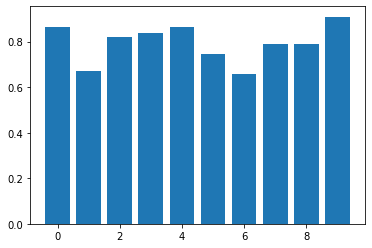

In [55]:
# Lets visualise a distribution of the results
plt.bar(range(10), cv_all)

In [56]:
model.fit(X_train_trans, y_train)
train_score = model.score(X_train_trans, y_train)
train_score

/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.811377245508982

In [57]:
X_train_trans.shape

(668, 19)

In [58]:
# Is the score inside the range?
train_score > cv_all.min() and train_score < cv_all.max()

True

In [59]:
# Is the score is inside one sigma?
train_score - cv_mean < cv_std 

True

In [60]:
test_score = model.score(X_test_trans, y_test)
test_score

0.8116591928251121

### Evaluate the models predictive power

In [61]:
y_pred = model.predict(X_test_trans)

#### Confusion matrix

In [62]:
#normalise the confusion matrix - its easier to interpret
norm_cm = (confusion_matrix(y_test, y_pred) / confusion_matrix(y_test, y_pred).sum()) * 100
norm_cm = norm_cm.round(2)
norm_cm

array([[51.57,  8.52],
       [10.31, 29.6 ]])

<AxesSubplot:>

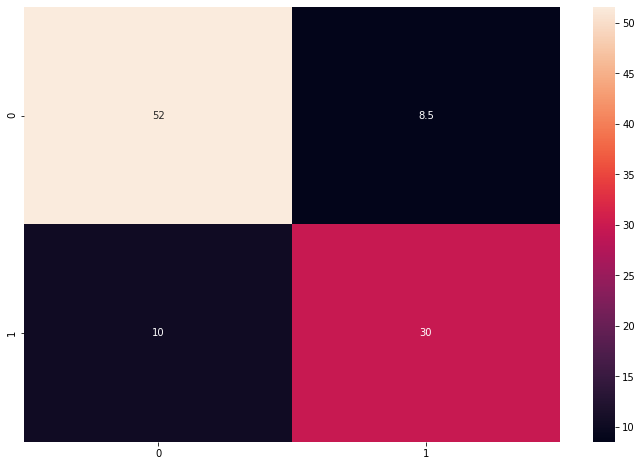

In [63]:
plt.figure(figsize=(12,8))
sns.heatmap(norm_cm, annot=True)

#### Roc curve

Text(0.5, 1.0, 'roc curve')

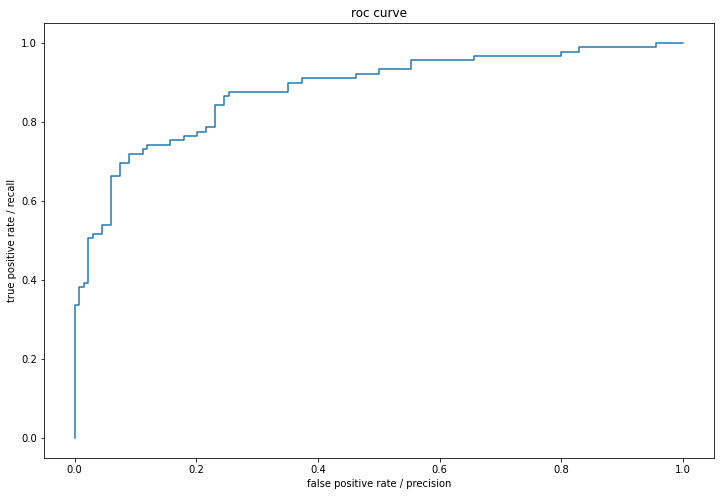

In [64]:
y_pred_proba = model.predict_proba(X_test_trans)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr)
plt.xlabel('false positive rate / precision')
plt.ylabel('true positive rate / recall')
plt.title('roc curve')

### Random Forest Classification Model

In [65]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=20, max_depth=2)
cross_val_score(m, X_train_trans, y_train, cv=5, scoring='accuracy')

array([0.75373134, 0.82835821, 0.73880597, 0.76691729, 0.81954887])

In [66]:
m.fit(X_train_trans, y_train)
m.score(X_train_trans, y_train)

0.7934131736526946

In [67]:
m.score(X_test_trans, y_test)

0.757847533632287